# Исследование алгоритма k-means

## Задача алгоритма:

Разделить объекты на кластеры (для сжатия и упрощения данных): 
    - Объекты в одном кластере похожи друг на друга;
    - Объекты в разных кластерах существенно отличаются.

## 5 основных шагов алгоритма k-means:
1. Выбраем количество кластеров k, которое нам кажется оптимальным для наших данных;
2. Раскидываем случайным образом в пространство наших данных k точек (центроидов);
3. Для каждой точки нашего набора данных считаем, к какому центроиду она ближе;
4. Перемещаем каждый центроид в центр выборки, которую мы отнесли к этому центроиду;
5. Повторяем последние два шага фиксированное число раз, либо до тех пор пока центроиды не "сойдутся".

## Реализация k-means:

In [1]:
%matplotlib inline
# для отображения графиков

In [2]:
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import random
import copy

### Алгоритм k-means:

In [3]:
def k_means(X, K):
    nrow = X.shape[0]
    ncol = X.shape[1]

    # выбераем K случайных точек (начальных центроидов) 
    initial_centroids = np.random.choice(nrow, K, replace=False)
    centroids = X[initial_centroids]

    centroids_old = np.zeros((K, ncol))
    cluster_assignments = np.zeros(nrow)

    while (centroids_old != centroids).any():
        centroids_old = centroids.copy()

        # вычисление расстояний между точками данных и центроидами
        dist_matrix = distance_matrix(X, centroids, p=2)

        # шаг 1: Найти ближайший центроид для каждой точки данных 
        for i in np.arange(nrow):
            d = dist_matrix[i]
            closest_centroid = (np.where(d == np.min(d)))[0][0]

            # связать точку с ближайшим центроидом
            cluster_assignments[i] = closest_centroid

        # шаг 2: пересчитать центроиды
        for k in np.arange(K):
            Xk = X[cluster_assignments == k]
            centroids[k] = np.apply_along_axis(np.mean, axis=0, arr=Xk)

    return (centroids, cluster_assignments)

### Построение графиков:

In [4]:
def take_plot(centroids, cluster_assignments, data):
    for j, core in enumerate(centroids):
        x = [ ]
        y = [ ]
        for i, line in enumerate(data):
            if (cluster_assignments[i] == j):
                # print(line)
                x.append(line[0])
                y.append(line[1])
        plt.scatter(x, y)
    for core in centroids:
        plt.scatter(core[0], core[1], c='black')
    plt.show()

### Матрица попарных расстояний:

In [5]:
def distance_table(centroids, cluster_assignments, data):
    i = np.argsort(cluster_assignments)
    lines2 = data[i, :]

    D = (lines2[:, 0][:, np.newaxis] - lines2[:, 0]) ** 2
    D += (lines2[:, 1][:, np.newaxis] - lines2[:, 1]) ** 2
    D = np.sqrt(D)
    plt.figure(figsize=(5, 4))
    plt.imshow(D, cmap='Purples_r', aspect='auto')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(orientation='vertical', pad=0.06);
    plt.show()

Применим алгоритм k-средних на наших данных, разбив их на два кластера:

In [6]:
data = []
with open("kmeans.txt") as f:
    for line in f:
        data.append([float(x) for x in line.split()])
data = np.array(data)

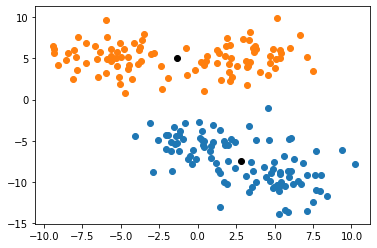

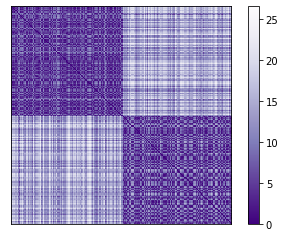

In [7]:
K = 2
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

take_plot(centroids, cluster_assignments, data)
distance_table(cluster_assignments = cluster_assignments, data = data, centroids = centroids)

Как видно из графика, такая стратегия инициализации работает достаточно хорошо. Попробуем увеличить число кластеров.

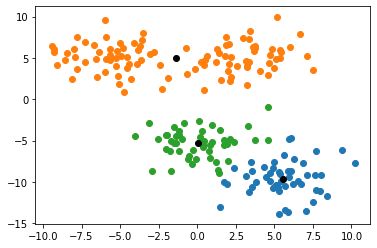

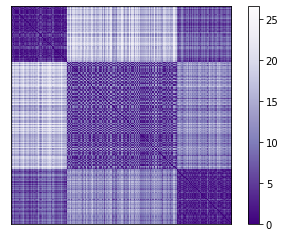

In [8]:
K = 3
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

take_plot(centroids, cluster_assignments, data)
distance_table(cluster_assignments = cluster_assignments, data = data, centroids = centroids)

При такой начальной инициализации результат также выглядит достаточно правдоподобным. С другой стороны, возможна также такая ситуация:

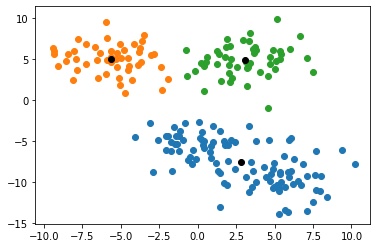

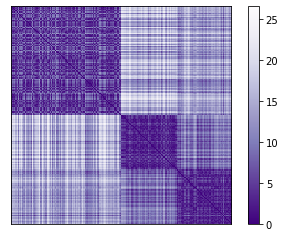

In [9]:
K = 3
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

take_plot(centroids, cluster_assignments, data)
distance_table(cluster_assignments = cluster_assignments, data = data, centroids = centroids)

Получается, случайная инициализация центров кластеров недостаточно надежна. Попробуем подобрать алгоритм, работающий стабильнее.

## Различные подходы к начальной инициализации:

В отличие от первого подхода, можно сначала случайным образом задать для каждой точки кластер, к которому она относится, а потом найти центры кластеров как покомпонентное среднее всех точек, относящихся к кластеру. Однако данный подход также не показывает удовлетворительных результатов.

In [10]:
K = 3
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

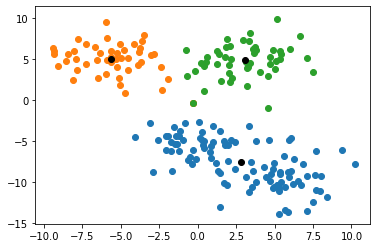

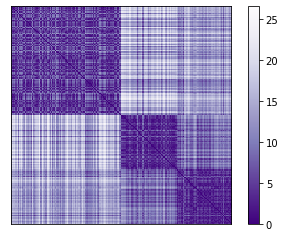

In [11]:
test_centroids = []
for j in range(K):
    test_centroid = random.choice(data)
    idx = np.where(data == test_centroid)
    test_data = np.delete(data, idx)
    test_counter = 0
    test_centroid -= test_centroid
    for i, line in enumerate(test_data):
        test_centroid += line
        test_counter += 1
    test_centroid /= (test_counter*1.0)
    test_centroids.append(test_centroid)
    
test_centroids = np.array(test_centroids)

centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

take_plot(centroids = centroids, cluster_assignments = cluster_assignments, data = data)
distance_table(cluster_assignments = cluster_assignments, data = data, centroids = centroids)

Возможен еще один способ: выбирать для начальной инициализации достаточно далекие точки. Однако это не решит проблемы, ведь точки в одном кластере могут быть как далекими, так и близкими относительно других кластеров. Плюс при увеличении числа векторов значительно вырастает сложность алгоритма.

В результате приходим к выводу, что случайная инициализация выглядит самой разумной и подходящей. В идеале, каждый раз необходимо проводить исследование объекта, к которому применяется k-means. В таком случае можно добиться более высокой точности.

## Для каких задач подходит k-means?

Данный алгоритм обладает сравнительно высокой эффективностью при достаточной простоте реализации. Однако, как мы уже заметили выше, он крайне чувствителен к начальной инициализации, а так же к случайным выбросам и шумам. K-means старается минимизировать среднеквадратичное отклонение на точках каждого кластера, используя евклидову метрику. Думаю, при использовании других метрик результат может поменяться. K-means формирует кластеры центрически. Из этого можно понять к каким задачам он лучше подходит.

Во время проведения исследования мне встретилась статья, в которой говорилось, что k-means часто используется при кластеризации изобржений и видео ввиду его простоты и быстрой скорости работы. Перед его применением, однако, необходимо очистить изобрадения от шума, пропустив их через определенные фильтры.

Существуют наборы данных, на которых он неприменим. Рассмотрим, например, такой вариант:

In [12]:
data = []
with open("data.txt") as f:
    for line in f:
        data.append([float(x) for x in line.split()])
data = np.array(data)

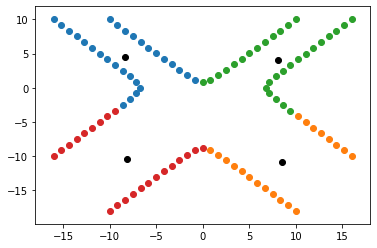

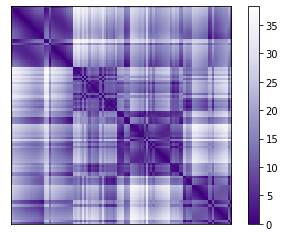

In [13]:
K = 4
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

take_plot(centroids, cluster_assignments, data)
distance_table(cluster_assignments = cluster_assignments, data = data, centroids = centroids)

Как мы видим из графика, подобное разбиение на кластеры соверщенно не соответствует действительности. 

Приведу еще один пример:

In [14]:
data = []
with open("data2.txt") as f:
    for line in f:
        data.append([float(x) for x in line.split()])
data = np.array(data)

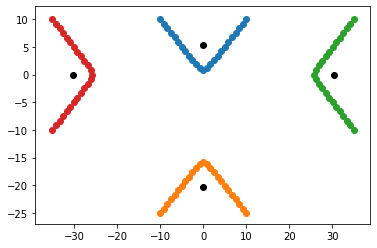

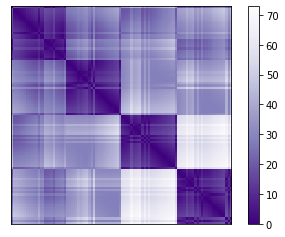

In [15]:
K = 4
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

take_plot(centroids, cluster_assignments, data)
distance_table(cluster_assignments = cluster_assignments, data = data, centroids = centroids)

А здесь алгоритм уже сработал верно. Получается, правильность его работы предсказать достаточно сложно. К тому же, в этих примерах нам было заранее известно число кластеров, на которые необходимо разбить данные, и потому качество кластеризации все-таки достаточно высоко. А как же следует действовать в том случае, когда число кластеров заранее неизвестно? Попробуем предложить алгоритм автоматического выбора числа кластеров.

## Стратегия выбора числа кластеров.

Наиболее удачным вариантом применения алгоритма k-means является ситуация, при которой нам заранее известно число кластеров, либо их количество можно рассчитать на основе анализа объекта, к которому применяется кластеризация. Например, если необходимо "распределить" игроков, забивших голы во время последнего матча, мы можем предположить, что количество образованных в результате кластеров будет равно трем, так как им будут соответсвовать следующие позиции игроков на поле — защитники, центральные защитники и нападающие. Такой подход вполне может быть применим в спортивной аналитике.

Однако чаще всего приходится сталкиваться с более общими задачами. В этом случае сделать такое очевидное предположение о наборе выходных данных невозможно. Рассмотрим второй способ. 

In [16]:
data = []
with open("kmeans.txt") as f:
    for line in f:
        data.append([float(x) for x in line.split()])
data = np.array(data)

In [17]:
def auto_KMeans(data, K):
    minimal_claster_dist = (int(K * (K - 1) / 9)) + K
    distance = (data[:, 0][:, np.newaxis] - data[:, 0]) ** 2
    distance += (data[:, 1][:, np.newaxis] - data[:, 1]) ** 2
    distance = np.sqrt(distance)
    minimal_claster_dist = np.sort(distance.ravel())[minimal_claster_dist]
    minimal_claster_dist *= 0.72
    distance[distance <= minimal_claster_dist] = 0
    dist_copy = np.zeros(K * K).reshape(K, K)
    while True:
        for i in range(K):
            zero_dist = distance[distance [i, :] == 0]
            zero_dist = np.min(zero_dist, axis=0)
            dist_copy[i, :] = zero_dist
        if np.array_equal(dist_copy, distance):
            break
        distance = dist_copy.copy()
    distance[distance != 0] = 1
    return len(np.sum(np.unique(distance, axis=0), axis=1))

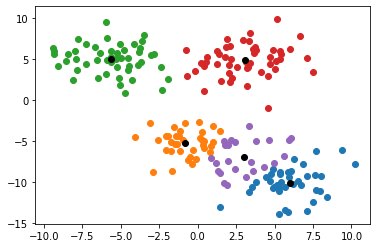

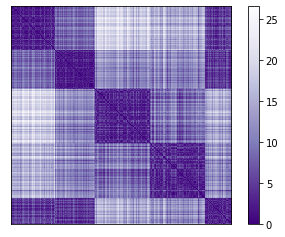

In [18]:
n_data=200
K = auto_KMeans(data, n_data)
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

take_plot(centroids, cluster_assignments, data)
distance_table(cluster_assignments = cluster_assignments, data = data, centroids = centroids)

## Визуализация матрицы попарных расстояний

В данном алгоритме будем опираться на уже существующий алгоритм нахождения покомпонентного среднего всех точек, относящихся к кластеру:

In [41]:
data = []
with open("kmeans.txt") as f:
    for line in f:
        data.append([float(x) for x in line.split()])
data = np.array(data)

In [42]:
K = 3
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

In [43]:
def swap_clusters(a, b, centroids, cluster_assignments):
    core = copy.deepcopy(centroids[a])
    centroids[a] = centroids[b]
    centroids[b] = core

    cluster_a_ind = np.argwhere(cluster_assignments == a)
    cluster_a_ind = np.reshape(cluster_a_ind, np.size(cluster_a_ind))

    cluster_b_ind = np.argwhere(cluster_assignments == b)
    cluster_b_ind = np.reshape(cluster_b_ind, np.size(cluster_b_ind))
    
    cluster_assignments = np.array(cluster_assignments)
    
    cluster_assignments[cluster_a_ind] = b*1.0
    cluster_assignments[cluster_b_ind] = a*1.0

    return centroids, cluster_assignments

In [44]:
def set_the_nearest_vectors(from_core, to_core, centroids, cluster_assignments, data, K):
    cluster_assignments = np.array(cluster_assignments)
    for i, cluster in enumerate(cluster_assignments):
        from_indexes = np.argwhere(cluster_assignments == from_core)
        from_vectors = np.take(data, np.reshape(from_indexes, np.size(from_indexes)), axis=0)

    for i, cluster in enumerate(cluster_assignments):
        to_indexes = np.argwhere(cluster_assignments == to_core)
        to_vectors = np.take(data, np.reshape(to_indexes, np.size(to_indexes)), axis=0)
        #print(to_indexes)
    if (np.size(from_vectors, axis=0) >= K) and (np.size(to_vectors, axis=0) >= K):
        pairs = np.zeros((K, np.size(data[0]), 2))
    else:
        pairs = np.zeros((min(np.size(from_vectors, axis=0), np.size(to_vectors, axis=0)), np.size(data[0]), 2))

    for i in range(np.size(pairs, axis=0)):
        min_dist = euclide_norm(from_vectors[0]-to_vectors[0])
        nearest_vectors = np.array([from_vectors[0], to_vectors[0]])
        for to_vector in to_vectors:
            for from_vector in from_vectors:
                dist = euclide_norm(from_vector - to_vector)
                if dist < min_dist:
                    min_dist = dist
                    nearest_vectors[0] = from_vector
                    nearest_vectors[1] = to_vector

        pairs[i] = nearest_vectors
        from_vectors = np.delete(from_vectors, from_vectors.tolist().index(nearest_vectors[0].tolist()), axis=0)
        to_vectors = np.delete(to_vectors, to_vectors.tolist().index(nearest_vectors[1].tolist()), axis=0)
    return pairs

In [45]:
def euclide_norm(vector):
    enorm = 0
    for coof in vector:
        enorm += coof ** 2
    return enorm

In [46]:
def average_dist_of_nearest_vecs(nearest_pairs):
    aver_dist = 0
    count = 0
    for pair in nearest_pairs:
        aver_dist += euclide_norm(pair[0] - pair[1])
        count += 1
    aver_dist /= (count * 1.0)
    return aver_dist

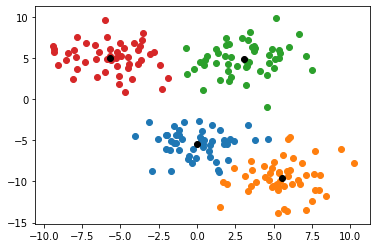

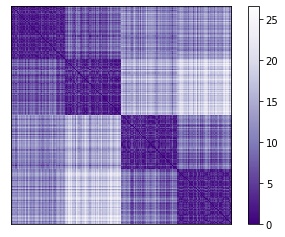

In [48]:
K=4
centroids, cluster_assignments = k_means(data, K)

data = np.array(data)


sorted_core_index = np.arange(np.size(centroids, axis=0))

near_pairs = set_the_nearest_vectors(0, 1, centroids=centroids, cluster_assignments=cluster_assignments, data=data, K=K)
min_dist = average_dist_of_nearest_vecs(near_pairs)


for i, core1 in enumerate(centroids[:-1]):
    for j, core2 in enumerate(centroids[i + 1:]):
        near_pairs = set_the_nearest_vectors(i, i + j + 1, centroids=centroids, cluster_assignments=cluster_assignments, data=data,
                                       K=K)
        dist = average_dist_of_nearest_vecs(near_pairs)
        if dist < min_dist:
            min_dist = dist
            first_index_core_pair = [i, j + i + 1]
        
centroids, cluster_assignments = swap_clusters(0, first_index_core_pair[0], centroids, cluster_assignments)
centroids, cluster_assignments = swap_clusters(1, first_index_core_pair[1], centroids, cluster_assignments)

for i, core1 in enumerate(centroids[1:-1]):
    min_dist_pairs = set_the_nearest_vectors(i, i + 1, centroids=centroids, cluster_assignments=cluster_assignments, data=data,
                                       K=K)
    min_dist = average_dist_of_nearest_vecs(min_dist_pairs)
    min_dist_index = i + 1
    for j, core2 in enumerate(centroids[i + 1:]):
        near_pairs = set_the_nearest_vectors(i, j + i + 1, centroids=centroids, cluster_assignments=cluster_assignments, data=data,
                                       K=K)
        dist = average_dist_of_nearest_vecs(near_pairs)
        if dist < min_dist:
            min_dist = dist
            min_dist_index = j + i + 1
    centroids, cluster_assignments = swap_clusters(i + 1, min_dist_index, centroids, cluster_assignments)

take_plot(centroids, cluster_assignments=cluster_assignments, data=data)
distance_table(cluster_assignments = cluster_assignments, data = data, centroids=centroids)

## Сложность алгоритма:
Сложность стандатного алгоритма $O(l^{nk+1})$, где $n$ – размерность пространств, $k$ – количество кластеров и $l$ – количество объектов. Попробуем проследить изменение времени работы алгоритма от количества векторов:

In [ ]:
import time

data = []
i = 0;
with open("data3.txt") as f:
    for line in f:
        i += 1
        data.append([float(x) for x in line.split()])
        if i == 100:
            break
data = np.array(data)

In [ ]:
start_time = time.time()

K = 4
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

print("%s seconds" % (time.time() - start_time))

In [ ]:
data = []
i = 0;
with open("data3.txt") as f:
    for line in f:
        i += 1
        data.append([float(x) for x in line.split()])
        if i == 1000:
            break
data = np.array(data)

In [89]:
start_time = time.time()

K = 4
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

print("%s seconds" % (time.time() - start_time))

0.16010308265686035 seconds


In [92]:
data = []
i = 0;
with open("data3.txt") as f:
    for line in f:
        i += 1
        data.append([float(x) for x in line.split()])
        if i == 10000:
            break
data = np.array(data)

In [93]:
start_time = time.time()

K = 4
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

print("%s seconds" % (time.time() - start_time))

1.2812130451202393 seconds


Как мы видим, при увеличении количества векторов время выполнения растет на порядок, т.к. при увеличении векторов увеличивается число итераций, но, в целом, скорость выполнения алгоритма достаточно высока. Попробуем увеличить число кластеров:

In [96]:
data = []
i = 0;
with open("data3.txt") as f:
    for line in f:
        i += 1
        data.append([float(x) for x in line.split()])
        if i == 100:
            break
data = np.array(data)

In [97]:
start_time = time.time()

K = 10
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

print("%s seconds" % (time.time() - start_time))

0.0302584171295166 seconds


In [98]:
data = []
i = 0;
with open("data3.txt") as f:
    for line in f:
        i += 1
        data.append([float(x) for x in line.split()])
        if i == 1000:
            break
data = np.array(data)

In [99]:
start_time = time.time()

K = 10
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

print("%s seconds" % (time.time() - start_time))

0.24298667907714844 seconds


In [100]:
data = []
i = 0;
with open("data3.txt") as f:
    for line in f:
        i += 1
        data.append([float(x) for x in line.split()])
        if i == 10000:
            break
data = np.array(data)

In [101]:
start_time = time.time()

K = 10
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

print("%s seconds" % (time.time() - start_time))

4.165570497512817 seconds


Можно заметить, что при увеличении числа кластеров чуть больше, чем в два раза, время выполнения возрастает. Для 10000 векторов время выполнения увеличивается в четыре раза.

А чего мелочиться, давайте сразу 100 кластеров сделаем:

In [134]:
data = []
i = 0;
with open("data3.txt") as f:
    for line in f:
        i += 1
        data.append([float(x) for x in line.split()])
        if i == 1000:
            break
data = np.array(data)

In [135]:
start_time = time.time()

K = 100
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

print("%s seconds" % (time.time() - start_time))

0.5097959041595459 seconds


In [136]:
data = []
i = 0;
with open("data3.txt") as f:
    for line in f:
        i += 1
        data.append([float(x) for x in line.split()])
        if i == 10000:
            break
data = np.array(data)

In [139]:
start_time = time.time()

K = 100
k_means_result = k_means(data, K)
centroids = k_means_result[0]
cluster_assignments = (k_means_result[1]).tolist()

print("%s seconds" % (time.time() - start_time))

6.712723970413208 seconds


Как мы видим, время выполнения растет. Однако все-таки незначительно. 